# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# !pip uninstall -y PIL
# !pip uninstall -y Pillow
# !pip install Pillow


In [2]:
# !pip install Pillow
# !pip install scipy
# !pip install --upgrade imageio
# !pip install --upgrade pillow

In [3]:
import numpy as np
import os
from imageio import imread, imwrite
from skimage.transform import resize
import datetime
import os

import  PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
rootPath = "Project_data/"
diffPath = "ProjectDiff_data/"

In [6]:
train_doc = np.random.permutation(open(rootPath + 'train.csv').readlines())
val_doc = np.random.permutation(open(rootPath + 'val.csv').readlines())
batch_size = 5

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
NUMBER_OF_SEQUENCES = 30
IMAGE_X = 25
IMAGE_Y = 25

In [8]:
def normalizeImageData(imageData, colorData):
    tmpImage = imageData.copy()
    
    
    #resize the image
    image_resized = resize(tmpImage, (IMAGE_X, IMAGE_Y), anti_aliasing=True)
    
    image_colorChannel = image_resized
    if(colorData != ""):
        #get the colorChannel
        image_colorChannel = image_resized[:,:,colorData]
        #plt.imshow(image_colorChannel)
    
    #normalize the data
    iqr75 = np.percentile(image_colorChannel, 75)
    iqr25 = np.percentile(image_colorChannel, 25)
    image_normalized = (image_colorChannel - iqr25)/(iqr75 - iqr25)
    #plt.imshow(image_normalized)
    
    return image_normalized

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(1, NUMBER_OF_SEQUENCES, 2)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        #print(t)
        num_batches = (NUMBER_OF_SEQUENCES // batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), IMAGE_X, IMAGE_Y ,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                imgs = sorted(imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = normalizeImageData(image, 0)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = normalizeImageData(image, 1)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = normalizeImageData(image, 2)#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = rootPath + 'train'
val_path = rootPath + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam, SGD, RMSprop

#write your model here

In [12]:
from keras.applications.vgg16 import VGG16
from keras import initializers
from keras.layers import Dropout

In [13]:
#filter_length = 32
#nb_filter = 16
#rnn_output_size = 64
#weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
dropout = 0.5
#hidden_dims = 128
output_classes = 5 

https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [14]:
def build_model():
    model = Sequential()
    
#     #Get weights from existing VGG + making the top 10 layers as non trainable 
#     VGG = VGG16(weights="imagenet",
#                     include_top=False,
#                     input_shape=(15, 100, 100, 3))
#     for layer in VGG.layers[:10]:
#         layer.trainable=False
#     model.add(VGG)
    
    
    #3d covolution layers + maxpooling +dropout
    model.add(Conv3D(64,
                    (2,2,2),
                    padding = 'same',
                    activation = 'relu',
                    input_shape=(15, 25, 25, 3)))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(dropout))  
    
    #3d covolution layers + maxpooling +dropout
    model.add(Conv3D(64,
                    (2,2,2),
                    padding = 'same',
                    activation = 'relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(dropout)) 
    
    model.add(TimeDistributed(Flatten()))
    
    #model.add(Dense(128))
    #GRU Layer
    model.add(GRU(512, activation='relu', return_sequences=False))
    model.add(Dropout(dropout))

    #model.add(Dense(32))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [15]:
model = build_model()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 25, 25, 64)    1600      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 12, 12, 64)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 12, 12, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 12, 12, 64)     32832     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 6, 6, 64)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 6, 6, 64)       0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 2304)           0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
callbacks_list = [checkpoint, LR, earlyStopping]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 5
Source path =  Project_data/train ; batch size = 5
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


133/133 [==============================] - 341s 3s/step - loss: 1.5876 - categorical_accuracy: 0.2707 - val_loss: 1.4196 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.41963, saving model to model_init_2020-06-2908_50_53.981563/model-00001-1.58764-0.27068-1.41963-0.51000.h5
Epoch 2/10
133/133 [==============================] - 431s 3s/step - loss: 1.3053 - categorical_accuracy: 0.4827 - val_loss: 1.2413 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 1.41963 to 1.24127, saving model to model_init_2020-06-2908_50_53.981563/model-00002-1.30532-0.48271-1.24127-0.49000.h5
Epoch 3/10
133/133 [==============================] - 369s 3s/step - loss: 0.9468 - categorical_accuracy: 0.6436 - val_loss: 0.7096 - val_categorical_accuracy: 0.7400

Epoch 00003: val_loss improved from 1.24127 to 0.70958, saving model to model_init_2020-06-2908_50_53.981563/model-00003-0.94679-0.64361-0.70958-0.74000.h5
Epoch 4/10
133/133 [=======================

1. With 3DConv + 3DConv + GRU with resize + normalize, getting an accuracy of 0.73 in 5 epochs.

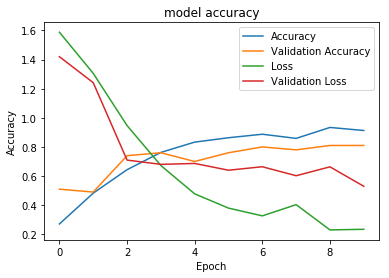

In [21]:
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.show()

To work with gesture, i think differences between frame and just getting the changes between frames would be better and find better results.

In [22]:
import cv2
import matplotlib as plot

In [23]:
#Other global variables
# Here, we define some colours
SCALAR_BLACK = (0.0,0.0,0.0)
SCALAR_WHITE = (255.0,255.0,255.0)

# This variable is created so that we can print necessary values while debugging.
# Creating this variable is good general practice.
SHOW_DEBUG_STEPS = False


#Try and find contour around red areas
# define range of red color in HSV
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])

In [24]:
def drawAndShowContours(wd,ht,contours,strImgName):
    global SCALAR_WHITE
    global SHOW_DEBUG_STEPS
    blank_image = np.zeros((ht,wd,3), np.uint8)
    cv2.drawContours(blank_image,contours,-1,SCALAR_WHITE,-1)
    
    if(SHOW_DEBUG_STEPS):
        cv2.imshow(strImgName,blank_image)
    return blank_image

In [25]:
#Create a bounding box using skin color or red color segmentation
def createBoundingBox(imgPath, imgName, debugOutput=False):
    orgImg = cv2.imread(imgPath + imgName)
    tmpImg = orgImg.copy()
    #print(tmpImg)
    #plt.imshow(tmpImg)
    #plt.show()

    sv = cv2.cvtColor(tmpImg,cv2.COLOR_BGR2HSV)

    # Threshold the HSV image to get only red colors
    red_mask = cv2.inRange(sv, lower_red, upper_red)
    if(debugOutput):
        plt.imshow(red_mask)
        plt.show()

    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(red_mask,kernel,iterations = 3)
    erode = cv2.erode(dilation,kernel,iterations = 1)
    if(debugOutput):
        plt.imshow(erode)
        plt.show()

    canny_output = cv2.Canny(erode, 100, 100*2)
    if(debugOutput):
        plt.imshow(canny_output)
        plt.show()

    contours = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    im2 = drawAndShowContours(canny_output.shape[0],canny_output.shape[1],contours,'imgContours')
    if(debugOutput):
        plt.imshow(im2)
        plt.show()

    largestHull = []
    largestArea= 0
    largestContour = []
    tmpHulls = contours.copy()
    for i in range(len(contours)):
        tmpHulls[i] = cv2.convexHull(contours[i])
        currentBoundingRect = cv2.boundingRect(tmpHulls[i])
        #curArea = (currentBoundingRect[2] - currentBoundingRect[0]) * (currentBoundingRect[3] - currentBoundingRect[1])
        curArea = (currentBoundingRect[2] *currentBoundingRect[3])
        if(largestArea == 0):
            largestArea = curArea
            largestHull = tmpHulls[i]
            largestContour = contours[i]
            #print(largestArea)
        elif(curArea > largestArea):
            largestArea = curArea
            largestHull = tmpHulls[i]
            largestContour = contours[i]
            #print(largestArea)


    x,y,w,h = cv2.boundingRect(largestHull)
    #cv2.rectangle(tmpImg,(x,y),(x+w,y+h),(0,255,0),2)

    #print(l)
    # Then we draw the contours    
    tmpImp1 = drawAndShowContours(canny_output.shape[0],canny_output.shape[1],tmpHulls,'imgConvexHulls')
    if(debugOutput):
        plt.imshow(tmpImp1)
        plt.show()

    valY = y
    valYEnd = y+h+25
    valX = x-15
    valXEnd = valX+w+25
    if(valX <0):
        valX=0

    #print(largestHullBoundingRect)
    #draw rectangle
    if(debugOutput):
        figure, ax = plt.subplots(nrows=1, ncols=1)
        rect = plot.patches.Rectangle((x, y),w,h, edgecolor='r', facecolor="none")
        ax.imshow(tmpImg)
        ax.add_patch(rect)
        plt.show()
    #print(y, y+h+50, x-25, x+w+50)
    
    boundedImg = orgImg[y:y+h,x:x+w]
    #boundedImg = tmpImg[valY:valYEnd,valX:valXEnd]
    
    return boundedImg

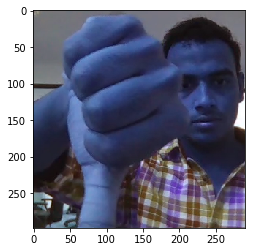

In [26]:
imgs = os.listdir("Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new/")
filteredImgList = [val for val in imgs if(val.endswith(".png"))]
srtImgList =  sorted(filteredImgList)
#print(srtImgList)
#print(filteredImgList[2])
foundImg = createBoundingBox("Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new/", srtImgList[-1])
#print(foundImg)
plt.imshow(foundImg)
plt.show()